Notebook 2: Análisis del modelo de regresión de Mínimos Cuadrados Parciales (PLS)

Introducción

En este notebook, nos enfocamos en el análisis del modelo de regresión de Mínimos Cuadrados Parciales (PLS) para analizar los datos de las bombas de agua. PLS es un método estadístico que combina características del análisis de componentes principales y la regresión múltiple. Es especialmente útil cuando necesitamos predecir un conjunto de variables dependientes a partir de un conjunto grande de variables independientes, y cuando hay multicolinealidad entre las características.

Cargaremos el mismo conjunto de datos utilizado en el notebook anterior y aplicaremos la regresión de PLS para modelar la relación entre las variables independientes y el rendimiento de la bomba de agua. El proceso implicará seleccionar el número óptimo de componentes, ajustar el modelo y evaluar su precisión predictiva.

Compararemos los resultados del PLS con los de otros modelos en el Notebook 6.

<a name="indice"></a>
# Índice

*   [Introducción](#intro)

*   [Libraries](#librerias)

*   [Preparación de los datos](#readingdata)

  - [Carga del conjunto de datos](#cargardatos)
  - [Conjuntos de entrenamiento y prueba](#limpiardatos)  

*   [Modelo de ANN](#modeloredes)

  - [Definición del modelo](#definicionmodelos)
  - [Entrenamiento del modelo](#entrenamientomodelos)
  - [Evaluación del modelo](#evaluacionmodelos)
  - [Importancia de las variables (SHAP)](#importanciavariables)

*   [Guardando los resultados](#guardar)


<a name="librerias"></a>

## Librerias

[Numpy](https://es.wikipedia.org/wiki/NumPy) es un paquete fundamental para la computación científica en Python, que proporciona soporte para matrices y arreglos multidimensionales de gran tamaño, junto con una colección de funciones matemáticas para operar eficientemente en estos arreglos.

[Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una biblioteca que ofrece estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar para Python. Su estructura de datos principal es el DataFrame, que permite almacenar y manipular datos tabulares en filas de observaciones y columnas de variables.

[Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una biblioteca de trazado de gráficos para Python y su extensión matemática numérica, NumPy. Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones utilizando herramientas de interfaz gráfica de usuario de propósito general como Tkinter, wxPython, Qt o GTK.

El módulo "random" implementa generadores de números pseudoaleatorios para diversas distribuciones y es útil para tareas como la selección aleatoria de muestras y la elección de elementos aleatorios de un rango o colección.

[Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn) (Sklearn) es una biblioteca de aprendizaje automático para Python que proporciona herramientas simples y eficientes para la minería de datos y el análisis de datos. Cuenta con varios algoritmos de clasificación, regresión y agrupamiento.

Google Colab es un servicio en la nube gratuito basado en Jupyter Notebooks que admite GPU gratuitas e integra con Google Drive. Se utiliza para la educación e investigación en aprendizaje automático, proporcionando un entorno fácil de usar para escribir y ejecutar código Python, lo cual es especialmente beneficioso para proyectos colaborativos.

In [ ]:
# Librerias generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Otras librerias auxiliares de scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Importamos las librerías para trabjar con PLS y varias funciones de estadística
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from zmq import NULL

# Libreria para el uso de archivos
from google.colab import drive

[(*volver al índice*)](#indice)

<a name="readingdata"></a>
# Preparado de datos

<a name="cargardatos"></a>
## Cargar el conjunto de datos

Cargamos los datos en memoria y comprobamos que todo funciona. Los datos ya están balanceados por el código anterior disponible en el Notebook 0.

La primera vez que te conectas el drive de Google te pide permiso para acceder y tienes que pinchar en aceptar dicho permiso.

In [ ]:
# Nombre del archivos con las X e Ys
X_FILE_NAME = "Datos_balanceados_X_6000.txt"
Y_FILE_NAME = "Datos_balanceados_Y_6000.txt"

# Nombre de los directorios con los ficheros
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
DATA_FOLDER    = "/Resultados/Balanceo de datos/"

# Montar el disco de drive
drive.mount('/content/drive')

# Guardamos el ID de cada sensor; notice that ID 15 is not in the list
sensorNames = ["SENSOR_00", "SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04",
               "SENSOR_05", "SENSOR_06", "SENSOR_07", "SENSOR_08", "SENSOR_09",
               "SENSOR_10", "SENSOR_11", "SENSOR_12", "SENSOR_13", "SENSOR_14",
               "SENSOR_16", "SENSOR_17", "SENSOR_18", "SENSOR_19", "SENSOR_20",
               "SENSOR_21", "SENSOR_22", "SENSOR_23", "SENSOR_24", "SENSOR_25",
               "SENSOR_26", "SENSOR_27", "SENSOR_28", "SENSOR_29", "SENSOR_30",
               "SENSOR_31", "SENSOR_32", "SENSOR_33", "SENSOR_34", "SENSOR_35",
               "SENSOR_36", "SENSOR_37", "SENSOR_38", "SENSOR_39", "SENSOR_40",
               "SENSOR_41", "SENSOR_42", "SENSOR_43", "SENSOR_44", "SENSOR_45",
               "SENSOR_46", "SENSOR_47", "SENSOR_48", "SENSOR_49", "SENSOR_50",
               "SENSOR_51"]

# Guardamos el significado de cada sensor
sensorProperties = ["Motor Casing Vibration", "Motor Frequency A",
                    "Motor Frequency B", "Motor Frequency C", "Motor Speed",
                    "Motor Current", "Motor Active Power",
                    "Motor Apparent Power", "Motor Reactive Power",
                    "Motor Shaft Power", "Motor Phase Current A",
                    "Motor Phase Current B", "Motor Phase Current C",
                    "Motor Coupling Vibration", "Motor Phase Voltage AB",
                    "Motor Phase Voltage BC", "Motor Phase Voltage CA",
                    "Pump Casing Vibration", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Inlet Flow", "Pump Discharge Flow", "Pump UNKNOWN",
                    "Pump Lube Oil Overhead Reservoir Level",
                    "Pump Lube Oil Return Temp", "Pump Lube Oil Supply Temp",
                    "Pump Thrust Bearing Active Temp",
                    "Motor Non Drive End Radial Bearing Temp 1",
                    "Motor Non Drive End Radial Bearing Temp 2",
                    "Pump Thrust Bearing Inactive Temp",
                    "Pump Drive End Radial Bearing Temp 1",
                    "Pump non Drive End Radial Bearing Temp 1",
                    "Pump Non Drive End Radial Bearing Temp 2",
                    "Pump Drive End Radial Bearing Temp 2",
                    "Pump Inlet Pressure", "Pump Temp Unknown",
                    "Pump Discharge Pressure 1", "Pump Discharge Pressure 2"]

# Recordamos que eliminamos los datos de los sensores 15 y 50. Así que
# procedemos a eliminar también los nombres de estas listas
#
# Pero el sensor 15, NO ESTÁ EN LA LISTA.
# Sólo quitamos el 50, que corresponde con la posición 49 (vaya lío)
del sensorProperties[49]
del sensorNames[49]

# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sensor 15 está vacía, esto es correcto
data_x = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + X_FILE_NAME, sep = " ", header=None)
data_y = pd.read_csv( PROJECT_FOLDER + DATA_FOLDER + Y_FILE_NAME, sep = " ", header=None)
data_y = data_y.astype(int)

# Renombramos los nombres de las columnas para mayor claridad
data_x.columns = sensorNames
data_y.columns = ["Y"]

print("Cargado de datos concluido")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargado de datos concluido


<a name="limpiardatos"></a>
## Conjunto de entramiento y test de datos

No hace falta dividir los datos en entrenamiento y test. Sin embargo, si hace falta normalizar los datos antes de ejecutar el algoritmo

In [ ]:
# Normalizamos las matrices X e Y. En nuestro caso ya están centradas y ninguna
# variable parace tener una escala diferente al resto que pueda afectar a la
# variabilidad, pero lo dejamos hecho por si acaso.
Xnorm = data_x - data_x.mean()
Xnorm = Xnorm / Xnorm.max()
Ynorm = data_y - data_y.mean()
Ynorm = Ynorm / Ynorm.max()

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = Xnorm.shape[0]
totalInputsColumns = Xnorm.shape[1]

[(*volver al índice*)](#indice)

<a name="pls"></a>
# Modelo con regresión parcial de componentes (PLS regression)

Uno de los problemas más comunes cuando defines un modelo del tipo que sea, ya sea mediante machine learning, o haciendo una recta de regresión simple, es definir las variables que vas a usar para adivinar el conjunto de variables que quieres predecir.

Puede ser que las variables que elijas presenten un problema de multicolinearidad, que signica que las variables están altamente correlacionadas y significan casi lo mismo. Tu modelo va a funcionar genial con los datos que tienes, pero va a hacer predicciones muy pobres en conjuntos de datos nuevos.

Una forma de solucionar esto es mediante reducción de dimensionalidad usando PCA. Pero a PCA no le importa que las predicciones salgan bien o mal, lo que hace es intentar maximizar la variabilidad entre las componentes y la variable de salida.

Para corregir eso, se usa PLS, que mezcla la variabilidad de PCA con la correlación entre las variables de entrada y salida.

En nuestro caso vamos a usar [PLS-DA](https://en.wikipedia.org/wiki/Partial_least_squares_regression) , que es un clasificador para variables discretas ya que nuestra Y puede ser 0 (la red no funciona) o 1 (la red funciona)

Aquí hay un vídeo [06:53] con una introducción sencilla a [PLS-DA](https://www.youtube.com/watch?v=zqFZ0mEc74k)

Y aquí hay un PDF con una introducción más detallada sobre la implementación de esta función, y en particular el algoritmo [NIPALS](http://users.cecs.anu.edu.au/~kee/pls.pdf) (Nonlinear Iterative Partial Least Squares)

In [ ]:
# Definimos una función que va a probar la misma función de PLSR para diferentes
# cantitades de componenetes. PLSR nos va a devolver el error cuadrado medio (MSE)
# para número de componentes que le digamos. Eso lo guardamos en un vector, y
# nos quedamos con el número de componentes que hace MSE mínimo.

# Al igual que en PCA, estó va a presentar un scree-plot. Aunque el MSE sea
# mínimo para un número de componentes determinado, es posible que sea más
# interesante usar un número de componentes distinto al mínimo si no hay mucha
# diferencia con respecto al MSE para ese número de componentes.

def optimise_pls_cv(X, Y, n_comp, plot_components=True):

    # Guardamos cual es el MSE minimo y el mejor modelo posible.
    #
    # Inicializamos el mejor resultado a MSE = 9999 y número de componentes
    # mayor al número total de variables que tenemos. Este es un resultado
    # imposible y está programado así a drede.
    #
    # Así forzamos a que la primera opción mejore el mejor resultado de
    # inicialización y no hace falta hacer casos especiales dentro del bucle.
    mse_minimo        = 99999
    mejor_componentes = n_comp + 10
    mejor_modelo_pls  = NULL
    mejor_validacion  = NULL

    # Guardamos todos los MSE aquí.
    mse = []

    # Generamos un vector con cada una de las cantidades de componentes posibles
    component = np.arange(1, n_comp)

    # Para componente, hacemos PLSR y encontramos el MSE
    for i in component:

        # Hacemos PLS
        modelo_pls_actual = PLSRegression(n_components = i)

        # Hacemos validación cruzada para ver que tal se comporta el modelo
        #
        # ---- Calculamos los Ŷ
        #
        #      El número por defecto para hacer la validación cruzada es 5,
        #      yo aquí le he puesto 10 sin ningún motivo en especial.
        #
        y_cv = cross_val_predict(modelo_pls_actual, X, Y, cv = 10)

        # ---- Hayamos MSE
        mse_actual = mean_squared_error(Y, y_cv)
        mse.append(mse_actual)
        #
        # comp = 100 * ( i + 1) / n_comp

        # Actualizamos el mejor modelo posible si encontramos uno mejor
        if(mse_minimo > mse_actual):
            mse_minimo        = mse_actual
            mejor_componentes = i
            mejor_modelo_pls  = modelo_pls_actual
            mejor_validacion  = y_cv


    # Indicamos cual ha sido el mejor número de componentes
    print("Sugerimos usar este número de componentes: ", mejor_componentes)

    # Opcionalmente, podemos enseñar la gráfica con los valores de MSE
    if (plot_components):
        with plt.style.context(('ggplot')):
             plt.plot( component,         np.array(mse), '-v', color = 'blue', mfc = 'blue')
             plt.plot( mejor_componentes, mse_minimo,    'P', ms = 10, mfc = 'red')
             plt.xlabel('Número de componentes PLS')
             plt.ylabel('MSE')
             plt.title('PLS')
             plt.xlim(left=-1)

        plt.show()


    # Ajustamos los datos al mejor modelo encontrado
    mejor_modelo_pls.fit(X, Y)
    y_c = mejor_modelo_pls.predict(X)

    # Calculamos los valores de R2 para calibración y validación cruzada (cross-validation ; cv)
    score_c  = r2_score(Y, y_c)
    score_cv = r2_score(Y, mejor_validacion)

    # Calculamos el MSE para calibración y validación cruzada
    mse_c  = mean_squared_error(Y, y_c)
    mse_cv = mean_squared_error(Y, mejor_validacion)

    print('R2 calib:'  + str(score_c))
    print('R2 CV:'     + str(score_cv))
    print('MSE calib:' + str(mse_c))
    print('MSE CV:'    + str(mse_cv))

    # Plot regression and figures of merit
    rangey = max(Y) - min(Y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(Y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, Y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,Y), Y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(Y, Y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')

    plt.show()

    print("Número óptimo de componentes:")
    print(mejor_componentes)


    return mejor_componentes

Ejecutamos la función con los datos normalizados

Sugerimos usar este número de componentes:  19


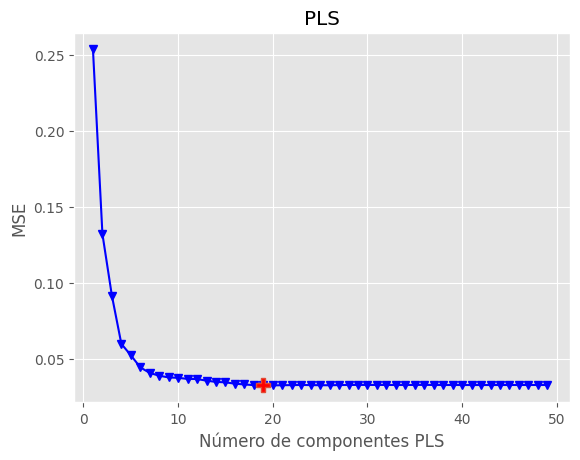

R2 calib:0.9741933414996553
R2 CV:0.9677047994930269
MSE calib:0.026167951719349502
MSE CV:0.03274733331407068


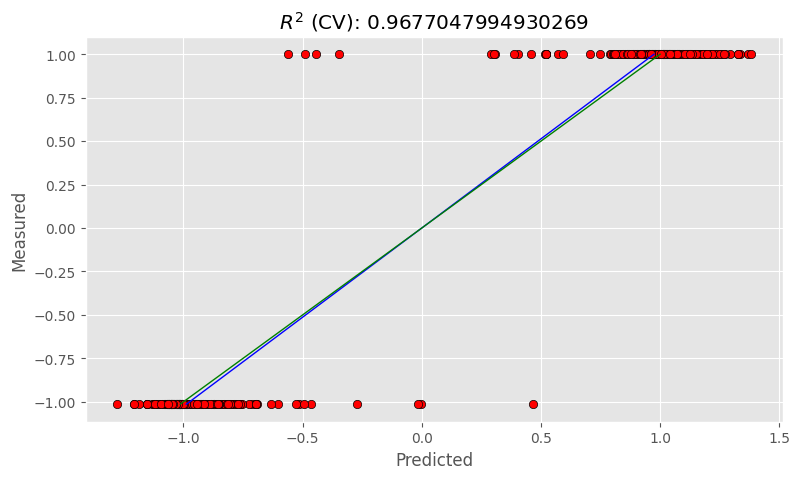

Número óptimo de componentes:
19


19

In [ ]:
optimise_pls_cv(Xnorm,Ynorm.squeeze(), totalInputsColumns , plot_components=True)

<a name="importanciavariables"></a>
## Importancia de cada variable.

SHapley Additive exPlanations (SHAP) calcula los valores de Shapley, que es un concepto de la Teoría de Juegos Cooperativos, para explicar la contribución de cada uno de los característica de entrada a la predicción final del modelo. SHAP se puede utilizar en cualquier algoritmo de aprendizaje y es fácil de interpretar, pero requiere un gran número de muestras para capturar adecuadamente las interacciones de las variables lo que es computacionalmente costoso.

Como regla general, los modelos que son difíciles de interpretar, como las redes neuronales, son mejores prediciendo resultados. Y los modelos que son más fáciles de interpretar, como los random forests, tienden más al sobreajuste o son peores prediciendo el resultado final.

In [ ]:
# Semilla aleatoria constante para reproducibilidad
# En este caso no se usa semilla, o de lo contrario los 200 resultados serían
# el mismo con una sigma = 0.

# Declaramos la proporción de datos que son para entrenar y para testear
TRAIN_PROPORTION = 0.8 # Esto significa el 80% de los datos para el conjunto
                       # de entrenamiento y el 20% para el conjunto test

# Inicializamos una variable donde guardaremos los datos de pesos de los coeficientes
plsData = np.zeros((200, 50))

# Generamos un vector donde guardamos las fiabilidades
vectorFiabilidades = np.zeros(200)

# Copio los datos que tenemos en otros dataframes por si acaso se modifican
df_x = pd.DataFrame(data_x)
df_y = pd.DataFrame(data_y.squeeze())

# Para cada modelo, generamos una fiabilidad distinta
# Usamos 200 iteraciones para que coincida con las iteraciones del SHAP
for j in range(0,200):

  # Creamos el modelo PLS
  pls2 = PLSRegression(n_components = 5)

  # Dividimos los datos en conjunto de entrenamiento y test igual que antes
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_x, data_y, test_size = (1 - TRAIN_PROPORTION))

  # Ajustar el modelo
  pls2.fit(Xtrain, Ytrain)

  # Predecir valores
  Y_pred = pls2.predict(Xtest)
  Y_addjusted = Y_pred.copy()

  # Los Ys se predicen por una función que dará un resultado continuo
  # Así que aquí se convierten los datos en lo que tenga más cerca cada uno
  # Convertir los Y_pred en 0s si es menor que 0.5, y al contrario para 1s
  for i in range(0,Y_pred.shape[0]):
    if(Y_addjusted[i] < 0.5): Y_addjusted[i] = 0
    else: Y_addjusted[i] = 1

  # Comparamos las predicciones con el conjunto del test
  predicciones = Y_addjusted == Ytest
  fiabilidad   = sum(predicciones['Y'])/Y_pred.shape[0]

  # Lo guardamos en el vector grande
  vectorFiabilidades[j] = fiabilidad

  # Igual que antes, guardamos los resultados para el vector de medias y sigmas
  plsData[j] = np.squeeze(pls2.coef_)


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will

In [ ]:
# Creamos un vector donde almacenamos los valores PLS para cada uno de los sensores
vectorMedias    = np.mean(plsData, axis=0)
vectorAbsMedias = np.mean(np.absolute(plsData), axis=0)
vectorSigmas    = np.std(plsData, axis=0)
vectorAbsSigmas = np.std(np.absolute(plsData), axis=0)


In [ ]:
# Comprobamos que las predicciones del PLS son fiables
print(np.mean(vectorFiabilidades))
print(np.std(vectorFiabilidades))


0.985
0.008544588873650042


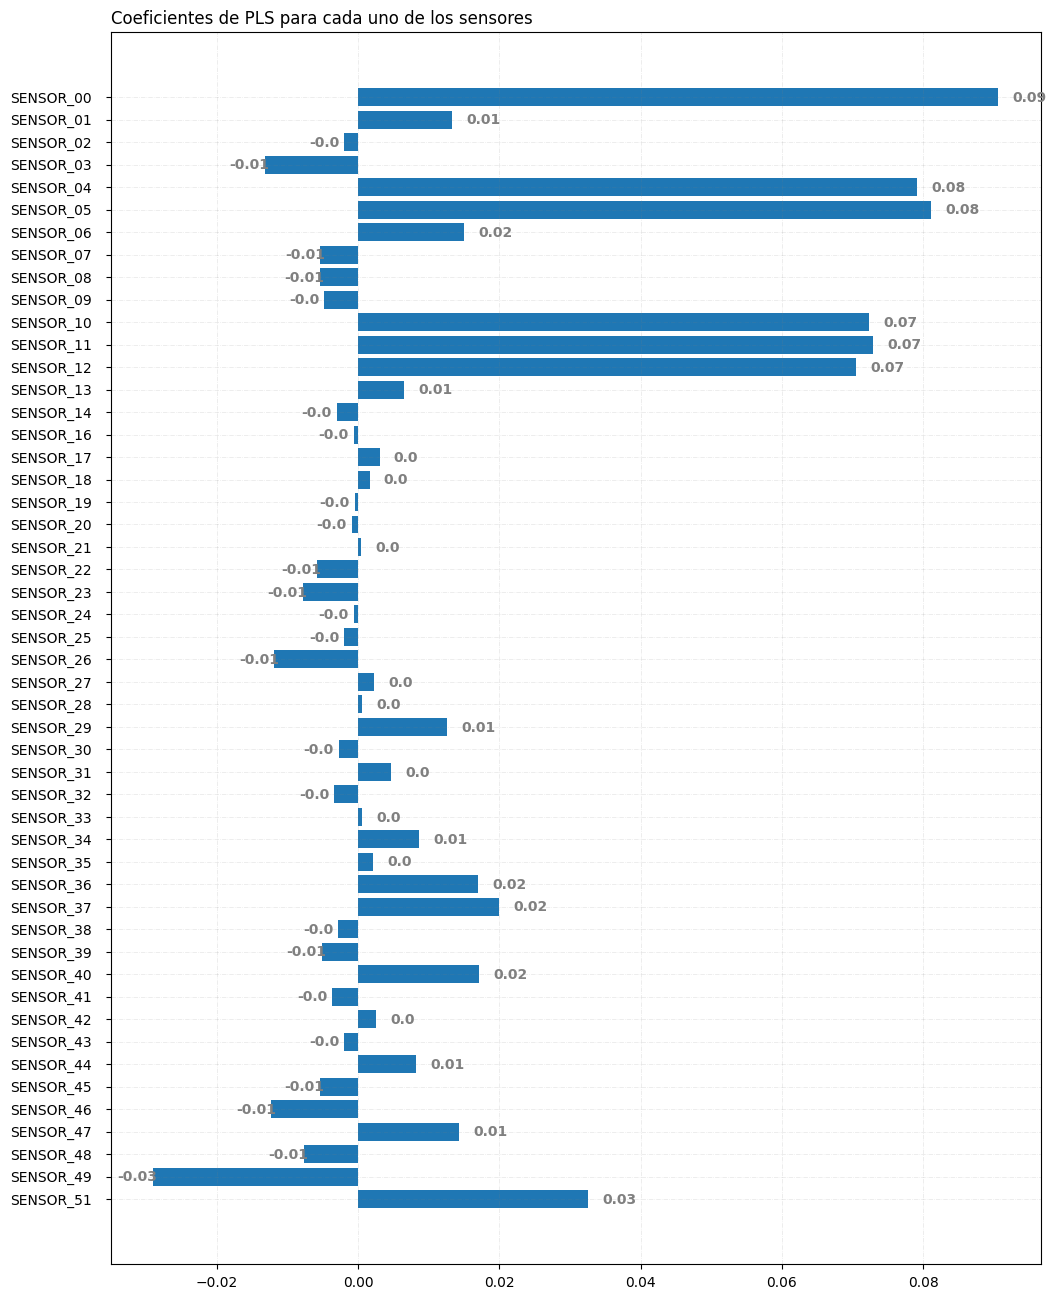

In [ ]:
# Usamos el último modelo generado para este gráfico. En la tabla final vermos
# las medias de todos los valores de todos los sensores de todos los métodos.
barplotData = pd.DataFrame( np.zeros([len(pls2.coef_),2]) )
barplotData[0] = data_x.columns
barplotData[1] = pls2.coef_

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Coeficientes de PLS para cada uno de los sensores',
             loc='left', )

# Show Plot
plt.show()

<a name="guardar"></a>

## Guardado de resultados

En esta sección guardamos todos los resultados y logs en la carpeta de Resultados/PLS del drive.

In [ ]:
# ------------------------------------------------------------------------------
# Valores medios absolutos y similares
# ------------------------------------------------------------------------------

# Nombre del fichero y directorio donde se guarda
PLS_WEIGHTS = 'PLS_Importancias_6000.csv'
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/PLS/'

# Se convierten los resultados a un dataframe
PLS_WEIGHTS_DF = pd.DataFrame({'Means':    np.squeeze(vectorMedias),
                               'AbsMeans': np.squeeze(vectorAbsMedias),
                               'Sigma':    np.squeeze(vectorSigmas),
                               'AbsSigma': np.squeeze(vectorAbsSigmas)})


# Guardar el resultado para que luego se pueda hacer el heatmap
PLS_WEIGHTS_DF.to_csv( BASE_FOLDER + PLS_WEIGHTS, index=False)

# ------------------------------------------------------------------------------
# Estadísticas del PLS (varianzas, pesos, ...)
# ------------------------------------------------------------------------------

# Hacemos las variables
total_variance_in_x  = np.var(Xtest, axis = 0)
variance_in_x        = np.var(pls2.x_scores_, axis = 0)
pesosPLSNormalizados = pls2.x_scores_ - np.dot(    scale(Xtrain)    ,    pls2.x_weights_    ) / pls2.x_scores_
pesosPLS             = pls2.x_scores_

# Preparamos el nombre de los ficheros
PLS_VARIANZA_TOTAL_X   = 'PLS_varianzaTotalX_6000.txt'
PLS_VARIANZA_X         = 'PLS_varianzaX_6000.txt'
PLS_PESOS_NORMALIZADOS = 'PLS_pesosNormalizados_6000.txt'
PLS_PESOS              = 'PLS_pesos_6000.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/PLS/'

np.savetxt(BASE_FOLDER + PLS_VARIANZA_TOTAL_X,   total_variance_in_x)
np.savetxt(BASE_FOLDER + PLS_VARIANZA_X,         variance_in_x)
np.savetxt(BASE_FOLDER + PLS_PESOS_NORMALIZADOS, pesosPLSNormalizados)
np.savetxt(BASE_FOLDER + PLS_PESOS,              pesosPLS)